### Libraries

In [493]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime,timedelta

In [495]:
data = pd.read_csv("Nat_Gas.csv")

In [497]:
data['Prices'] = data['Prices'].astype(float)
data['Dates'] = pd.to_datetime(data['Dates'], format='%m/%d/%y')

# convert date as index
data.set_index('Dates', inplace=True)
data = data.asfreq('ME')  # Month End frequency


In [499]:
print(data.index.min())
print(data.index.max())

2020-10-31 00:00:00
2024-09-30 00:00:00


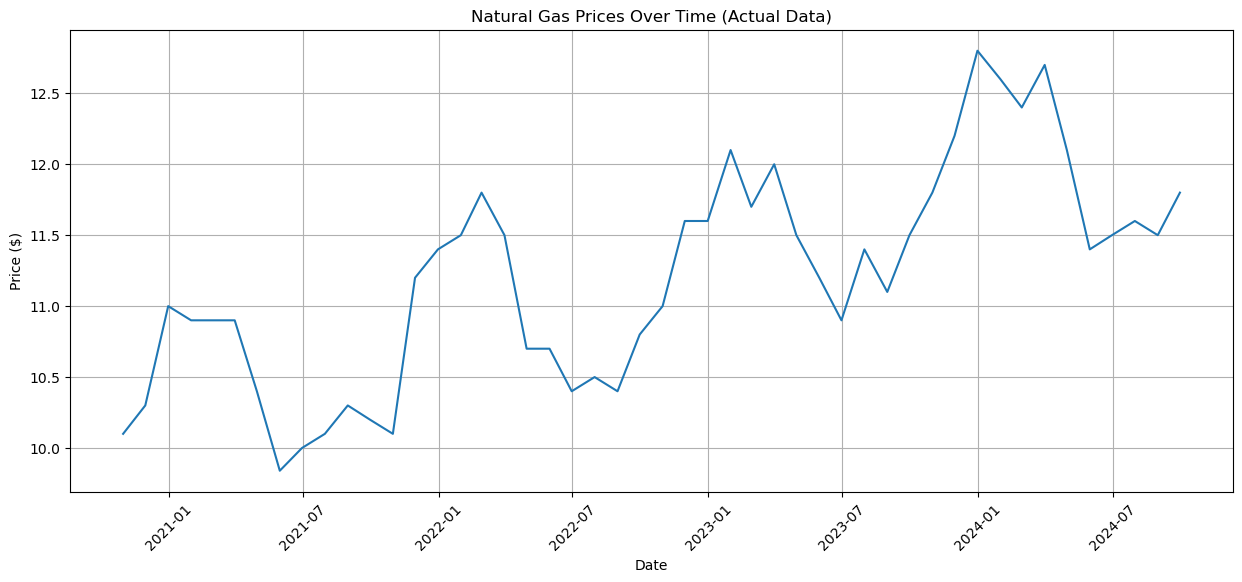

In [501]:
plt.figure(figsize=(15,6))
plt.plot(data.index,data['Prices'])
plt.title('Natural Gas Prices Over Time (Actual Data)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Price ($)')
plt.grid(True)
plt.show()

### seasonal trends and residual component analysis 

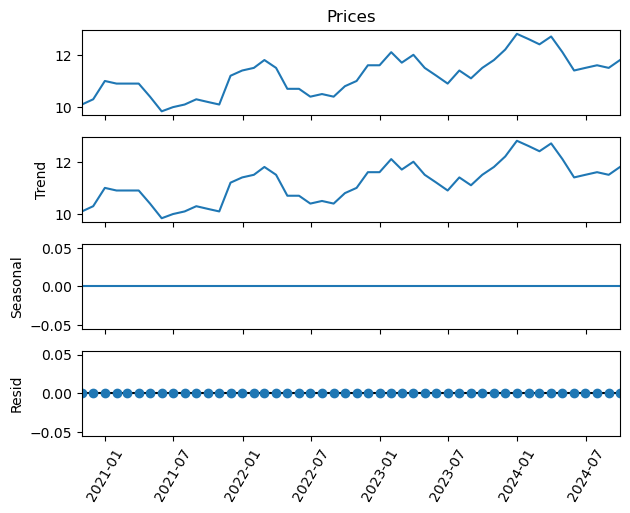

In [504]:
time_series=seasonal_decompose(data['Prices'],model="additive",period=1)
time_series.plot()
plt.xticks(rotation=60)
plt.show()

## ARIMA [ Autoregressive Integrated Moving Average]

In [507]:
data.shape

(48, 1)

In [509]:
# assume 30 rows for train and 18 rows for testing
train=data[:-18]
test=data[-18:]

In [511]:
model = ARIMA(train['Prices'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit()

C:\Users\ajith\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [513]:
forecast = model_fit.get_forecast(steps=18)
forecast_data = pd.DataFrame({
        'Date': test.index,
        'Actual': test['Prices'],
        'Forecast': forecast.predicted_mean
    })

In [515]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Prices'], forecast.predicted_mean))
print(f"Model Validation RMSE: {rmse:.2f}")

Model Validation RMSE: 0.27


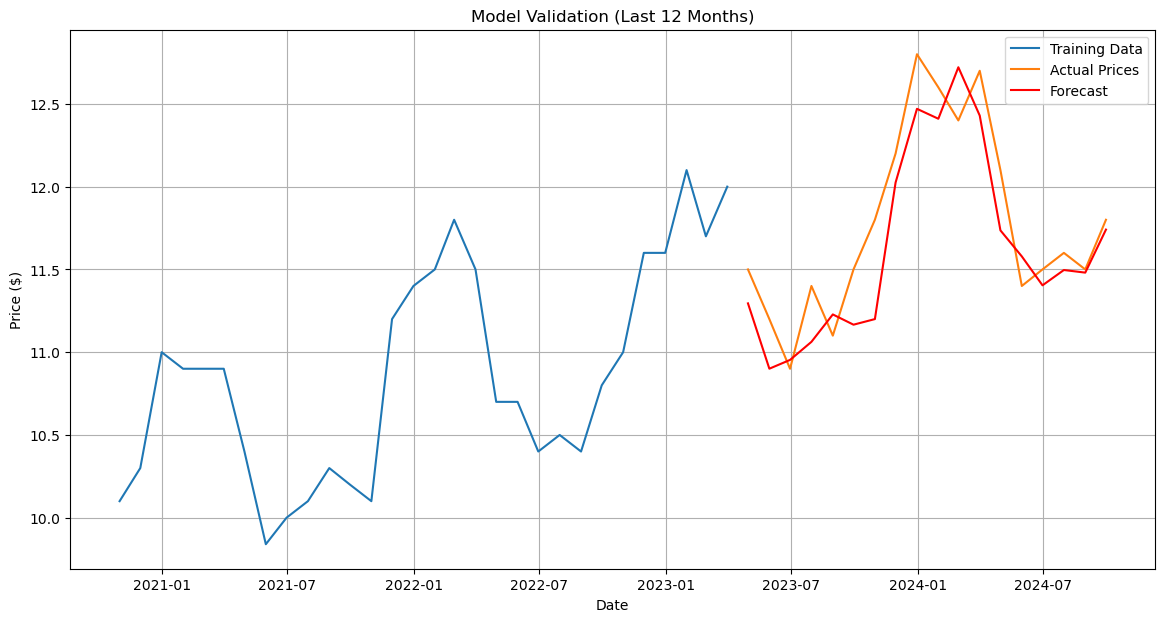

In [517]:
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Prices'], label='Training Data')
plt.plot(test.index, test['Prices'], label='Actual Prices')
plt.plot(test.index, forecast.predicted_mean, label='Forecast', color='red')
plt.title('Model Validation (Last 12 Months)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

In [519]:
def estimate_price(input_date, data, model):
    input_date = datetime.strptime(input_date, '%m/%d/%Y')
    if input_date <= data.index[-1]:
        historical_date = data.index[data.index <= input_date][-1]
        return data.loc[historical_date, 'Prices']
    months_diff = (input_date.year - data.index[-1].year) * 12 + (input_date.month - data.index[-1].month)
    if input_date.day > data.index[-1].day:
        months_diff += 1
    
    if months_diff <= 0:
        return data.iloc[-1]['Prices']
    
    forecast = model_fit.forecast(steps=months_diff)
    return forecast.iloc[-1]

# Estimating the price at different dates

In [522]:
print(f"Price on 2021-06-15: ${estimate_price('06/15/2021', data, model):.2f}")
print(f"Price on 2025-08-15: ${estimate_price('08/15/2025', data, model):.2f}")


Price on 2021-06-15: $9.84
Price on 2025-08-15: $12.72


# Forecast of the price of Natural Gas from OCT-24 to SEP-25

In [525]:
def visualize_forecast(data, model):
    forecast = model.get_forecast(steps=12)
    forecast_index = pd.date_range(start=data.index[-1] + pd.offsets.MonthEnd(1), periods=12, freq='ME')
    
    # Combine the historical and forecast data using pd.concat
    combined_index = data.index.append(forecast_index)
    combined_prices = pd.concat([data['Prices'], forecast.predicted_mean])

    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data['Prices'], label='Historical Prices')
    plt.plot(forecast_index, forecast.predicted_mean, label='12-Month Forecast', color='red')

    plt.title('Natural Gas Price Forecast (Oct 2024 - Sep 2025)')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True)

    # Set x-axis ticks at 3-month intervals for combined data (historical + forecast)
    plt.xticks(combined_index[::3], rotation=45)  # x-ticks every 3 months

    plt.show()

    print("\n12-Month Price Forecast:")
    forecast_data = pd.DataFrame({
        'Date': forecast_index,
        'Forecasted Price': forecast.predicted_mean,
    })
    print(forecast_data.round(2))


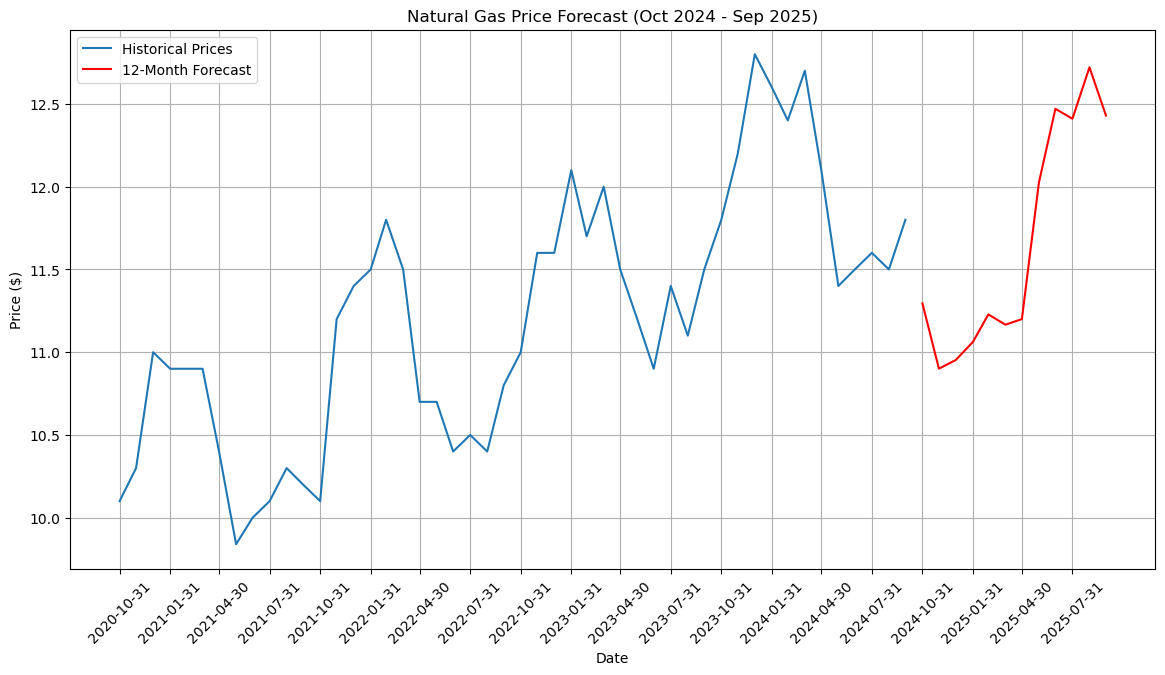


12-Month Price Forecast:
                 Date  Forecasted Price
2023-04-30 2024-10-31             11.29
2023-05-31 2024-11-30             10.90
2023-06-30 2024-12-31             10.95
2023-07-31 2025-01-31             11.06
2023-08-31 2025-02-28             11.23
2023-09-30 2025-03-31             11.17
2023-10-31 2025-04-30             11.20
2023-11-30 2025-05-31             12.02
2023-12-31 2025-06-30             12.47
2024-01-31 2025-07-31             12.41
2024-02-29 2025-08-31             12.72
2024-03-31 2025-09-30             12.43


In [527]:
visualize_forecast(data, model_fit)